In [38]:
import os
import os.path as osp
import json
import random
from imageio import imread
import numpy as np
import cv2
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

DATASET_DIR = '/opt/ml/input/data/ICDAR17_Korean/images/'

path = osp.join('/opt/ml/input/data/ICDAR17_Korean/ufo/K-fold_train1.json')
with open(path, 'r') as f:
    data = json.load(f)
    
file_lst = data['images'].keys()

def draw_bbox(image, bbox, color=(0, 0, 255), thickness=2, double_lined=False,
              write_point_numbers=False):
    """이미지에 하나의 bounding box를 그려넣는 함수"""
    basis = max(image.shape[:2])
    fontsize = basis / 1500
    x_offset, y_offset = int(fontsize * 12), int(fontsize * 10)
    color_sub = (255 - color[0], 255 - color[1], 255 - color[2])

    points = [(int(np.rint(p[0])), int(np.rint(p[1]))) for p in bbox]

    for idx in range(len(points)):
        if double_lined:
            cv2.line(image, points[idx], points[(idx + 1) % len(points)], color_sub,
                     thickness=thickness)
        cv2.line(image, points[idx], points[(idx + 1) % len(points)], color, thickness=thickness)

    if write_point_numbers:
        loc1 = (points[0][0], points[0][1] - y_offset)
        loc2 = (points[1][0], points[1][1] - y_offset)
        if double_lined:
            cv2.arrowedLine(image, loc1, loc2, color_sub, thickness)
        cv2.arrowedLine(image, loc1, loc2, color, thickness)


def draw_bboxes(image, bboxes, color=(0, 0, 255), thickness=2,
                double_lined=False, write_point_numbers=False):
    """이미지에 다수의 bounding box들을 그려넣는 함수"""
    for bbox in bboxes:
        draw_bbox(image, bbox, color=color, thickness=thickness,
                  double_lined=double_lined, write_point_numbers=write_point_numbers)
        

def gray_mask_to_heatmap(x):
    x = cv2.cvtColor(cv2.applyColorMap(x, cv2.COLORMAP_JET), cv2.COLOR_BGR2RGB)
    return x


def get_superimposed_image(image, score_map, heatmap=True, w_image=None, w_map=None):
    """이미지에 map/mask 등을 중첩하여 그려주는 함수
    
    Args:
        image (ndarray): (H, W, C) shaped, float32 or uint8 dtype is allowed.
        score_map (ndarray): (H, W) shaped, float32 or uint8 dtype is allowed.
        heatmap (boot): Wheather to convert `score_map` into a heatmap.
        w_image (float)
        w_map (float)

    Blending weights(`w_image` and `w_map`) are default to (0.4, 0.6).
    """

    assert w_image is None or (w_image > 0 and w_image < 1)
    assert w_map is None or (w_map > 0 and w_map < 1)

    if image.dtype != np.uint8:
        image = (255 * np.clip(image, 0, 1)).astype(np.uint8)

    if score_map.dtype != np.uint8:
        score_map = (255 * np.clip(score_map, 0, 1)).astype(np.uint8)
    if heatmap:
        score_map = gray_mask_to_heatmap(score_map)
    elif score_map.ndim == 2 or score_map.shape[2] != 3:
        score_map = cv2.cvtColor(score_map, cv2.COLOR_GRAY2RGB)

    if w_image is None and w_map is None:
        w_image, w_map = 0.4, 0.6
    elif w_image is None:
        w_image = 1 - w_map
    elif w_map is None:
        w_map = 1 - w_image

    return cv2.addWeighted(image, w_image, score_map, w_map, 0)

['견인지역', '###', '칼덱스', 'GS', '###', '1412', '1173', '###', '###', '###', '###', '###', '세차안내']


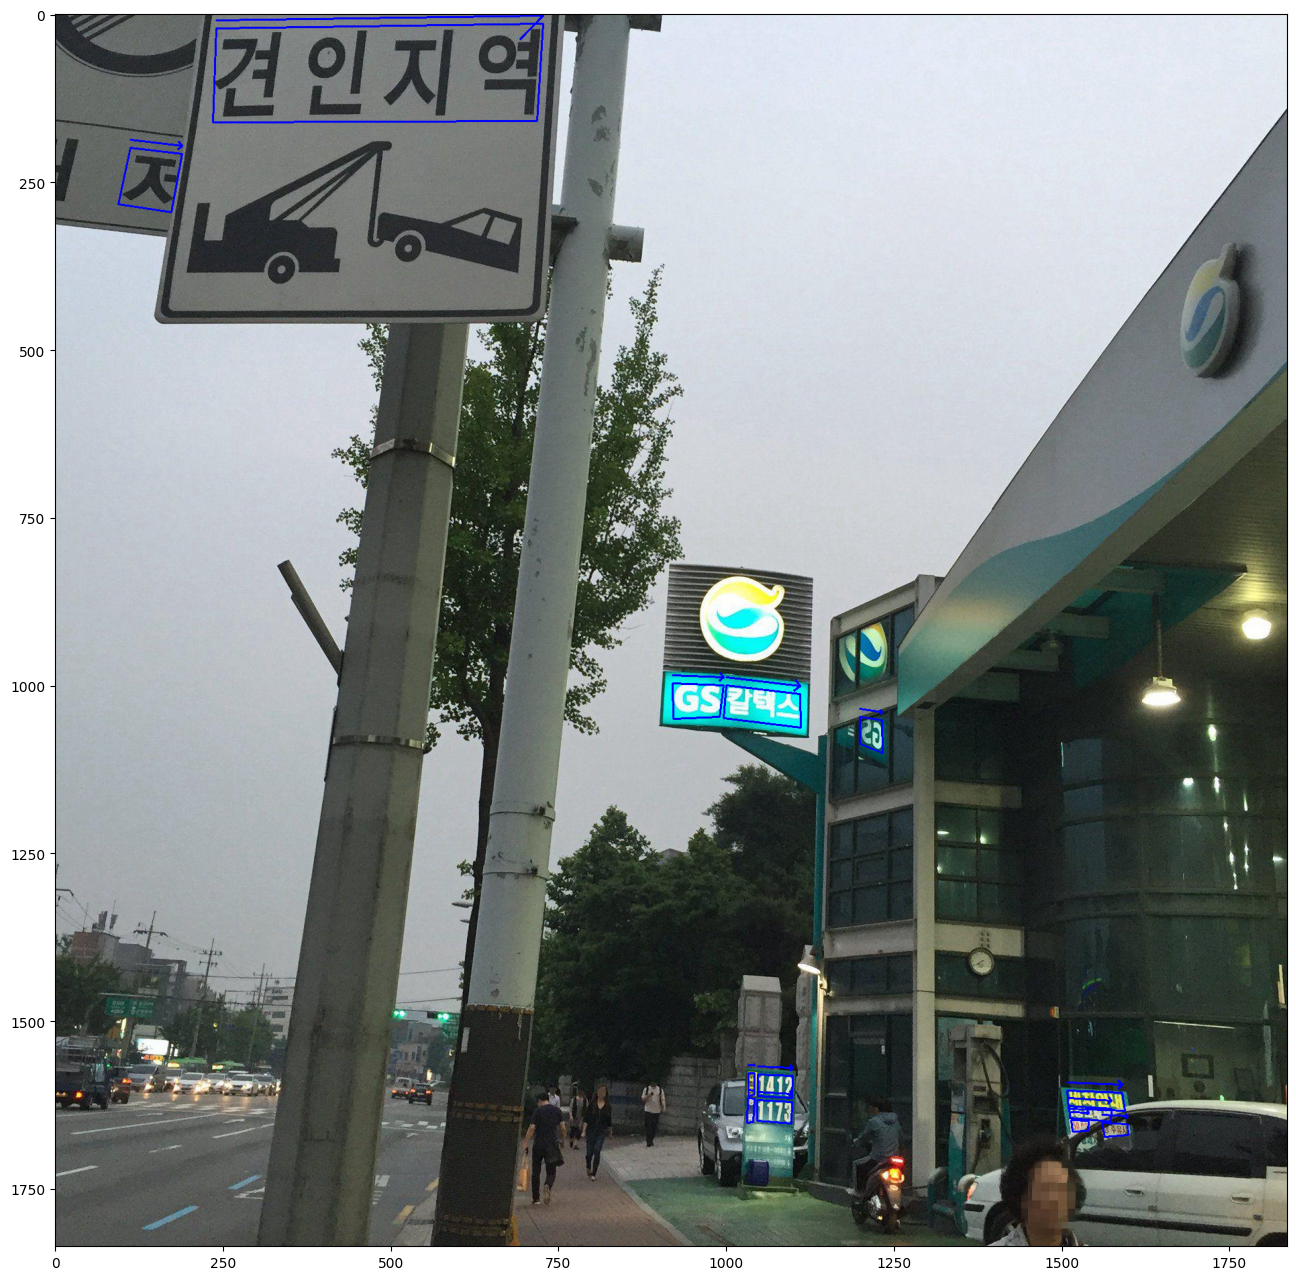

In [41]:
number = random.sample(file_lst, 1)
image = imread(DATASET_DIR + number[0])
visual = image.copy()

bboxes, labels = [], []
trans = []
for word_info in data['images'][number[0]]['words'].values():
    bboxes.append(np.array(word_info['points']))
    labels.append(int(not word_info['illegibility']))

for name in data['images'][number[0]]['words']:
    # print(name)
    trans.append(data['images'][number[0]]['words'][name]['transcription'])
print(trans)    

bboxes, labels = np.array(bboxes), np.array(labels)

draw_bboxes(visual, bboxes, double_lined=True, thickness=2, write_point_numbers=True)

plt.figure(figsize=(16, 16))
plt.imshow(visual)